<a href="https://colab.research.google.com/github/Nuthan03/Time-series/blob/main/time_series_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 3: Time series forecasting (BitPredict)

## Get data

we are going to be using the historical price data of Bitcoin to try and predict the future price of Bitcoin, we dowloaded the data from coinbase

In [1]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv

--2024-01-04 00:55:23--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 178509 (174K) [text/plain]
Saving to: ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’

BTC_USD_2013-10-01_ 100%[===================>] 174.33K  --.-KB/s    in 0.02s   

2024-01-04 00:55:23 (10.7 MB/s) - ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’ saved [178509/178509]



## Importing time series with pandas

In [2]:
# Import pandas
import pandas as pd
# Let's read in our Bitcoin data and parse the dates
df = pd.read_csv("/content/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv",
                 parse_dates=["Date"],
                 index_col=["Date"]) # prase the date column and tell pandas column 1 is a datetime

df.head()

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2013-10-01,BTC,123.65499,124.30466,124.75166,122.56349
2013-10-02,BTC,125.45500,123.65499,125.75850,123.63383
2013-10-03,BTC,108.58483,125.45500,125.66566,83.32833
2013-10-04,BTC,118.67466,108.58483,118.67500,107.05816
2013-10-05,BTC,121.33866,118.67466,121.93633,118.00566


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2787 entries, 2013-10-01 to 2021-05-18
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Currency             2787 non-null   object 
 1   Closing Price (USD)  2787 non-null   float64
 2   24h Open (USD)       2787 non-null   float64
 3   24h High (USD)       2787 non-null   float64
 4   24h Low (USD)        2787 non-null   float64
dtypes: float64(4), object(1)
memory usage: 130.6+ KB


In [4]:
# How many samples do we have ?
df.count()

Currency               2787
Closing Price (USD)    2787
24h Open (USD)         2787
24h High (USD)         2787
24h Low (USD)          2787
dtype: int64

We've collected the historical price of Bitcoin for the past ~ 8 years but there's 2787 samples.

Typically deep learning models usually like lots and lots and lots of samples (where lots and lots and lots can thousands to tens of thousands to millions).

A smaller number of samples is something you'll often run into with time series data problems.

In [5]:
# Only want closing price for each day
bitcoin_prices = pd.DataFrame(df["Closing Price (USD)"]).rename(columns={"Closing Price (USD)": "Price"})
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


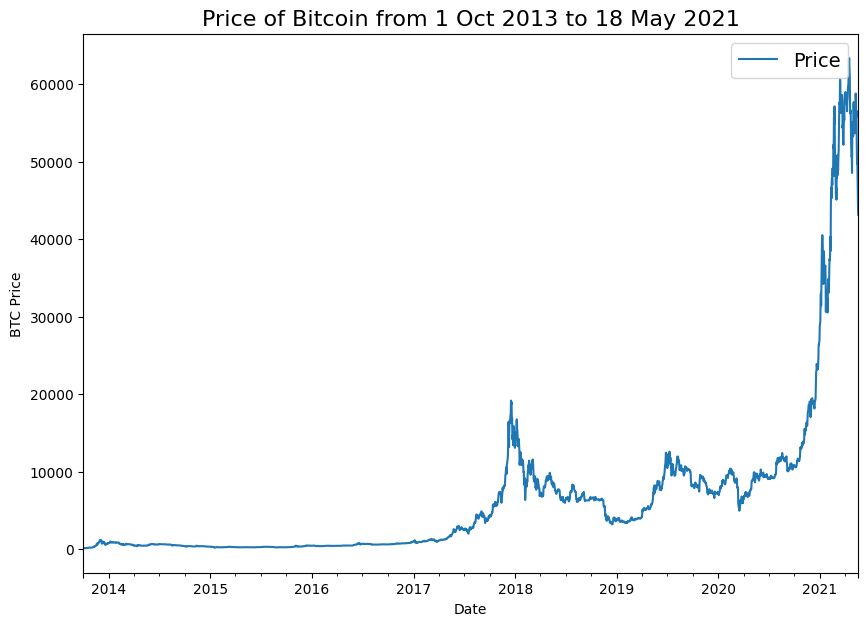

In [6]:
import matplotlib.pyplot as plt
bitcoin_prices.plot(figsize=(10, 7))
plt.ylabel("BTC Price")
plt.title("Price of Bitcoin from 1 Oct 2013 to 18 May 2021", fontsize=16)
plt.legend(fontsize=14);

## Importing time series data with Python's CSV module

In [7]:
# Importing and formatting historical Bitcoin data with python
import csv
from datetime import datetime

timesteps  = []
btc_price = []
with open("/content/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv", "r") as f:
  csv_reader = csv.reader(f, delimiter=",")
  next(csv_reader) # Skip the first line(get's rid of the column titles)
  for line in csv_reader:
    timesteps.append(datetime.strptime(line[1], "%Y-%m-%d")) # get the dates as dates
    btc_price.append(float(line[2])) # get the closing prices as float

# View first 10 of each
timesteps[:10], btc_price[:10]

([datetime.datetime(2013, 10, 1, 0, 0),
  datetime.datetime(2013, 10, 2, 0, 0),
  datetime.datetime(2013, 10, 3, 0, 0),
  datetime.datetime(2013, 10, 4, 0, 0),
  datetime.datetime(2013, 10, 5, 0, 0),
  datetime.datetime(2013, 10, 6, 0, 0),
  datetime.datetime(2013, 10, 7, 0, 0),
  datetime.datetime(2013, 10, 8, 0, 0),
  datetime.datetime(2013, 10, 9, 0, 0),
  datetime.datetime(2013, 10, 10, 0, 0)],
 [123.65499,
  125.455,
  108.58483,
  118.67466,
  121.33866,
  120.65533,
  121.795,
  123.033,
  124.049,
  125.96116])

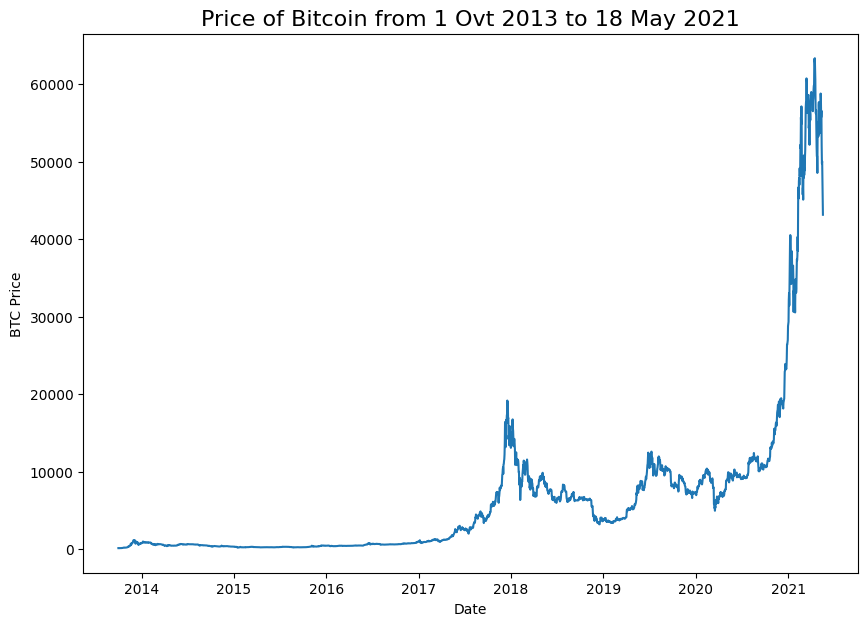

In [8]:
# Plot from csv
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(10, 7))
plt.plot(timesteps, btc_price)
plt.ylabel("BTC Price")
plt.title("Price of Bitcoin from 1 Ovt 2013 to 18 May 2021", fontsize=16)
plt.xlabel("Date");

## Format data part 1: Create train and test sets of our time series data

### Creating train and test sets with time series data(the wrong way)

In [9]:
# Get bitcoin data array
timesteps = bitcoin_prices.index.to_numpy()
prices = bitcoin_prices["Price"].to_numpy()

timesteps[:10], prices[:10]

(array(['2013-10-01T00:00:00.000000000', '2013-10-02T00:00:00.000000000',
        '2013-10-03T00:00:00.000000000', '2013-10-04T00:00:00.000000000',
        '2013-10-05T00:00:00.000000000', '2013-10-06T00:00:00.000000000',
        '2013-10-07T00:00:00.000000000', '2013-10-08T00:00:00.000000000',
        '2013-10-09T00:00:00.000000000', '2013-10-10T00:00:00.000000000'],
       dtype='datetime64[ns]'),
 array([123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
        121.795  , 123.033  , 124.049  , 125.96116]))

In [10]:
# Wrong way to make train/test sets for time series data
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(timesteps, # dates
                                                    prices, # prices
                                                    test_size=0.2,
                                                    random_state=42)

x_train.shape, x_test.shape, y_train.shape, y_test.shape

((2229,), (558,), (2229,), (558,))

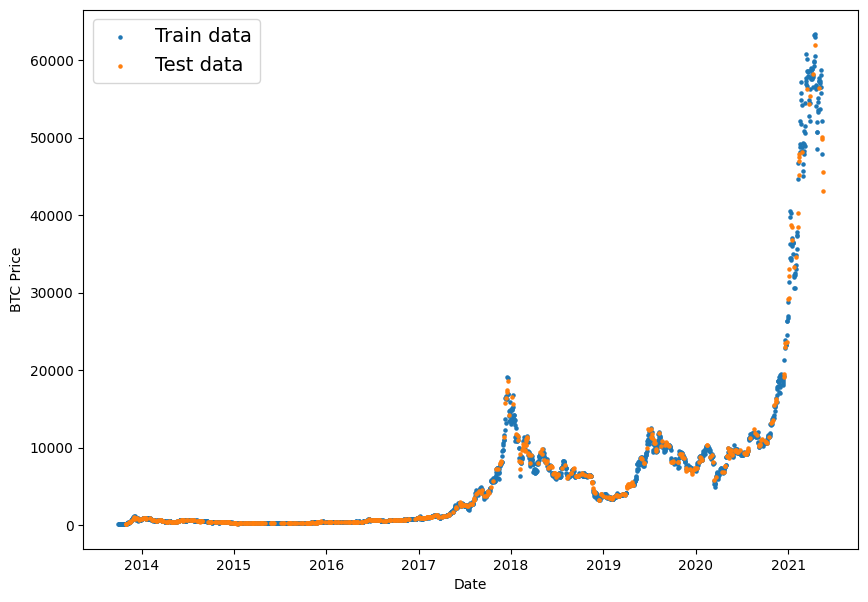

In [11]:
# Let's plot wrong train and test splits
plt.figure(figsize=(10, 7))
plt.scatter(x_train, y_train, s=5, label="Train data")
plt.scatter(x_test, y_test, s=5, label="Test data")
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.legend(fontsize=14)
plt.show();

### Create train and test sets for time series (the right way)

In [12]:
# Create train and test splits the right way for time series data
split_size = int(0.8 * len(prices)) # 80% train, 20% test

# Create train data splits (everything before the split)
x_train, y_train = timesteps[:split_size], prices[:split_size]

# Create test data splits (everything beyond the split)
x_test, y_test = timesteps[split_size:], prices[split_size:]

len(x_train), len(x_test), len(y_train), len(y_test)

(2229, 558, 2229, 558)

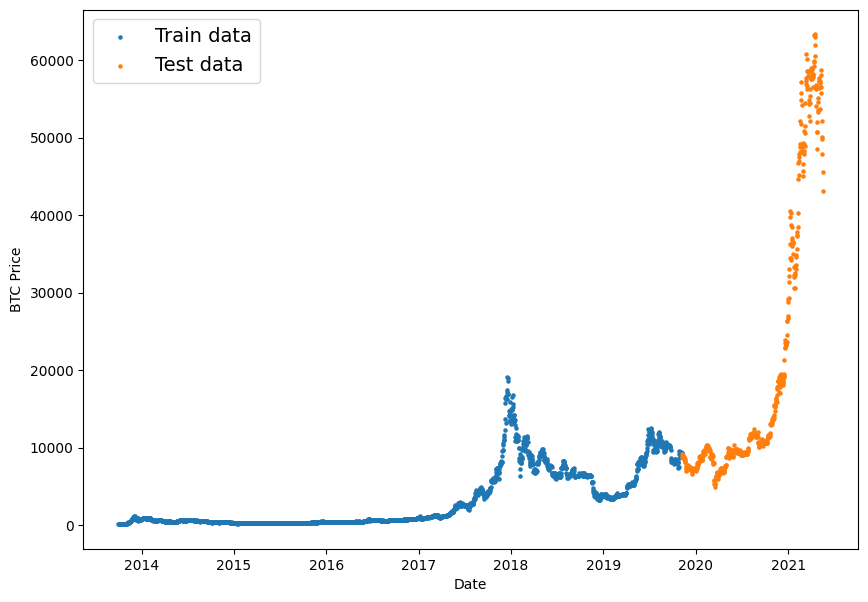

In [13]:
# Plot correctly made splits
plt.figure(figsize=(10, 7))
plt.scatter(x_train, y_train, s=5, label="Train data")
plt.scatter(x_test, y_test, s=5, label="Test data")
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.legend(fontsize=14)
plt.show();

## Create a plotting function

In [14]:
# Create a function a plot time series data
def plot_time_series(timesteps, values, format='.', start=0, end=None, label=None):
  """
   Plots a timesteps (a series of points in time) against values (a series of values across timesteps).

  Parameters
  ---------
  timesteps : array of timesteps
  values : array of values across time
  format : style of plot, default "."
  start : where to start the plot (setting a value will index from start of timesteps & values)
  end : where to end the plot (setting a value will index from end of timesteps & values)
  label : label to show on plot of values
  """

  # Plot the series


  plt.plot(timesteps[start:end], values[start:end], format, label=label)
  plt.xlabel("Time")
  plt.ylabel("BTC Price")
  if label:
    plt.legend(fontsize=14) # make label bigger
  plt.grid(True)

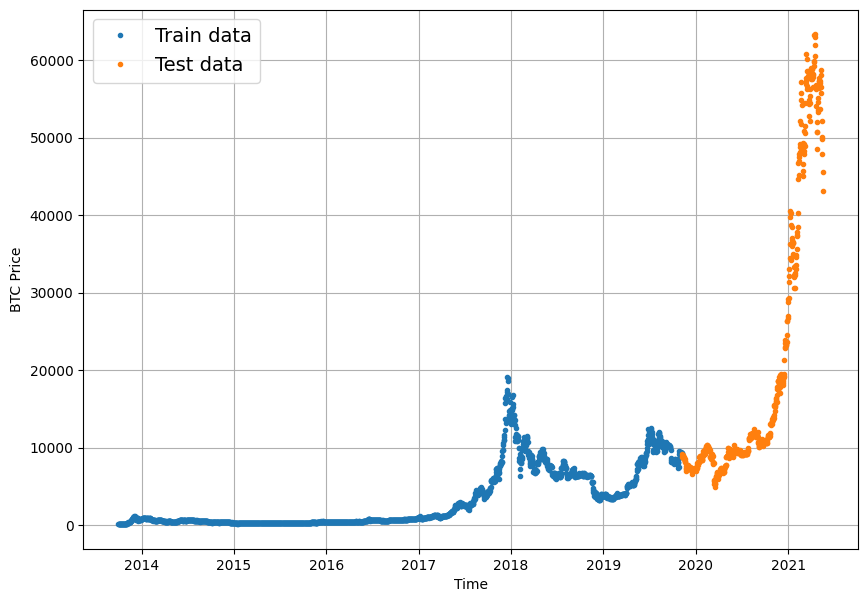

In [15]:
# Test out plotting function
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=x_train, values=y_train, label="Train data")
plot_time_series(timesteps=x_test, values=y_test, label="Test data")

## Modelling Experiments

we have got some Bitcoin historical data, to model it, let's run a series of modelling experiments and see which model performs best.

Terms to be familiar with:

  * **horizon** = number of timesteps to predict into future
  * **window** = number of timesteps from past used to predict **horizon**


| Model Number | Model Type | Horizon size | Window size | Extra data |
| ----- | ----- | ----- | ----- | ----- |
| 0 | Naïve model (baseline) | NA | NA | NA |
| 1 | Dense model | 1 | 7 | NA |
| 2 | Same as 1 | 1 | 30 | NA |
| 3 | Same as 1 | 7 | 30 | NA |
| 4 | Conv1D | 1 | 7 | NA |
| 5 | LSTM | 1 | 7 | NA |
| 6 | Same as 1 (but with multivariate data) | 1 | 7 | Block reward size |
| 7 | [N-BEATs Algorithm](https://arxiv.org/pdf/1905.10437.pdf) | 1 | 7 | NA |
| 8 | Ensemble (multiple models optimized on different loss functions) | 1 | 7 | NA |
| 9 | Future prediction model (model to predict future values) | 1 | 7 | NA|
| 10 | Same as 1 (but with turkey 🦃 data introduced) | 1 | 7 | NA |

## Model 0: Naive forecast(baseline)

The formula looks like this:

$$\hat{y}_{t} = y_{t-1}$$

In English:
> The prediction at timestep `t` (y-hat) is equal to the value at timestep `t-1` (the previous timestep).



In [16]:
# Create a naive forecast
naive_forecast = y_test[:-1]

naive_forecast[:10], naive_forecast[-10:]


(array([9226.48582088, 8794.35864452, 8798.04205463, 9081.18687849,
        8711.53433917, 8760.89271814, 8749.52059102, 8656.97092235,
        8500.64355816, 8469.2608989 ]),
 array([57107.12067189, 58788.20967893, 58102.19142623, 55715.54665129,
        56573.5554719 , 52147.82118698, 49764.1320816 , 50032.69313676,
        47885.62525472, 45604.61575361]))

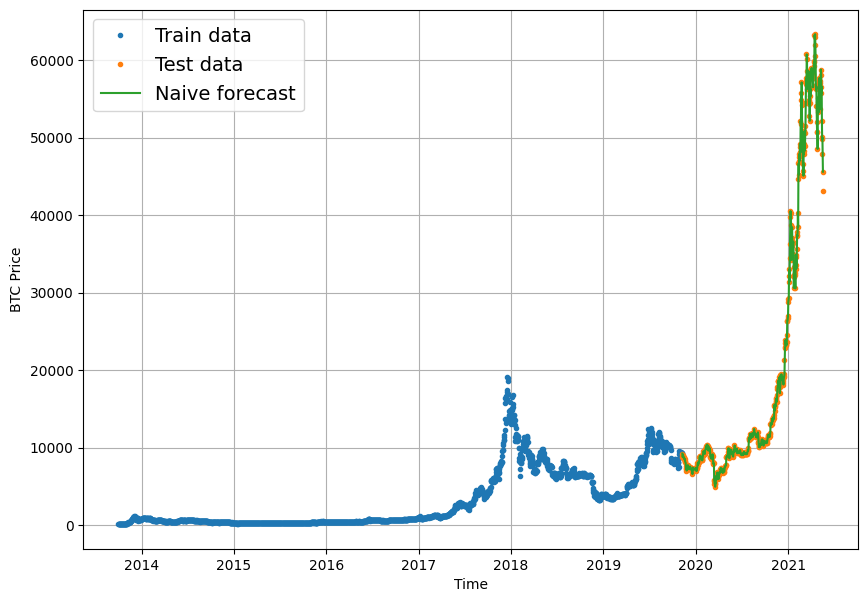

In [17]:
# Plot naive forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=x_train, values=y_train, label="Train data")
plot_time_series(timesteps=x_test, values=y_test, label="Test data")
plot_time_series(timesteps=x_test[1:], values=naive_forecast, format="-", label="Naive forecast");

## Evaluating a time series model

Let's look into some evaluation metrics for time series forecasting.

We're predicting a number, so that means we have a form of a regression problem.

Because we're working on a regression problem, we'll need some regression-like metrics.

A few common regression metrics (which can also be used for time series forecasting):
* MAE : mean absolute error
* MSE : mean squared error
* RMSE : root mean squared error
* MAPE/sMAPE-(symmetric)mean absolute percentage error
* MASE : mean absolute scaled error



In [18]:
# Let's get tensorflow
import tensorflow as tf

In [19]:
# MASE implementation
def mean_absolute_scaled_error(y_true, y_preds):
  """
  Implemet MASE (assuming no seasonality of data)
  """
  mae = tf.reduce_mean(tf.abs(y_true - y_preds))

  # Find MAE of navie forecast (no seasonality)
  mae_navie_no_season = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:1]))

  return mae / mae_navie_no_season

In [20]:
mean_absolute_scaled_error(y_true=y_test[1:], y_preds=naive_forecast).numpy()

0.04742710938980206

In [21]:
# Create a function to take in model predictions and truth values and return evaluation metrics
def evaluate_preds(y_true, y_pred):
  # Make sure float32 (for metric calculations)
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate various evaluation metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)

  return {
      "mae": mae.numpy(),
      "mse": mse.numpy(),
      "rmse": rmse.numpy(),
      "mape": mape.numpy(),
      "mase": mase.numpy()
  }

In [22]:
naive_results = evaluate_preds(y_true = y_test[1:],
                               y_pred = naive_forecast)
naive_results

{'mae': 567.9802,
 'mse': 1147547.0,
 'rmse': 1071.2362,
 'mape': 2.516525,
 'mase': 0.04742711}

In [23]:
# Find average price of Bitcoin in test dataset
tf.reduce_mean(y_test).numpy()

20056.632963737222

## Other models you can use for baseline and for actual forecasts

In this notebook, we're focused on TensorFlow and deep learning models.

However there are plenty of other styles of time series forecasting models you want to experiment with:

| **Model/Library Name** | **Resource** |
| ----- | ----- |
| Moving average | https://machinelearningmastery.com/moving-average-smoothing-for-time-series-forecasting-python/ |
| ARIMA (Autoregression Integrated Moving Average) | https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/ |
| sktime (Scikit-Learn for time series) | https://github.com/alan-turing-institute/sktime |
| TensorFlow Decision Forests (random forest, gradient boosting trees) | https://www.tensorflow.org/decision_forests |
| Facebook Kats (purpose-built forecasting and time series analysis library by Facebook) | https://github.com/facebookresearch/Kats |
| LinkedIn Greykite (flexible, intuitive and fast forecasts) | https://github.com/linkedin/greykite |

## Foremat Data Part 2: Windowing dataset
Why do we window?

We window our time series dataset to turn our data into a supervised learning problem.


```
Window for one week (univariate time series)

[0, 1, 2, 3, 4, 5, 6] -> [7]
[1, 2, 3, 4, 5, 6, 7] -> [8]
[2, 3, 4, 5, 6, 7, 8] -> [9]
```

Or for the price of Bitcoin, it'd look like:

```
Window for one week with the target of predicting the next day (Bitcoin prices)

[123.654, 125.455, 108.584, 118.674, 121.338, 120.655, 121.795] -> [123.033]
[125.455, 108.584, 118.674, 121.338, 120.655, 121.795, 123.033] -> [124.049]
[108.584, 118.674, 121.338, 120.655, 121.795, 123.033, 124.049] -> [125.961]
```

In [24]:
len(y_train)

2229

In [25]:
# Let's setup global variables for window and horizon size
HORIZON = 1
WINDOW_SIZE = 7

In [26]:
# Create a function to label windowed data
def get_labeled_window(x, horizon=HORIZON):
  """
  Creates labels for windowed dataset.

  E.g. if horizon=1
  Input: [0,1,2,3,4,5,6,7]-> Output: ([1,2,3,4,5], [6])
  """
  return x[:, :-horizon], x[:, -horizon:]

In [27]:
# Test out the window labelling function
test_window, test_label = get_labeled_window(tf.expand_dims(tf.range(8)+1, axis=0))
print(f"Window: {tf.squeeze(test_window).numpy()} -> Label: {tf.squeeze(test_label).numpy()}")

Window: [1 2 3 4 5 6 7] -> Label: 8


We've got a way to label our windowed data.

However, this only works on small scale

we need a way to do the above across our entire time series.

We could do this with python for loops,however, for large time series, that'd be quite slow.

To speed things up, we'll leverage Numpy's array indexing.

Our function will:

1. Create a window step of specified window size (e.g. [0,1,2,3,4,5,6])
2. Use NumPy indexing to create a 2D array of multiple window steps, for example:
```
[[0, 1, 2, 3, 4, 5, 6, 7],
 [1, 2, 3, 4, 5, 6, 7, 8],
 [2, 3, 4, 5, 6, 7, 8, 9]]
```
3. Uses the 2D array of multuple window steps to index on a target series
4. Uses the `get_labelled_windows()` function we created above to turn the window steps into windows with a specified horizon

> 📖 **Resource:** The function created below has been adapted from Syafiq Kamarul Azman's article [*Fast and Robust Sliding Window Vectorization with NumPy*](https://towardsdatascience.com/fast-and-robust-sliding-window-vectorization-with-numpy-3ad950ed62f5).

In [38]:
# Create a function to view NumPy arrays as windows
def make_windows(x, window_size=WINDOW_SIZE, horizon=HORIZON):
  """
  Turns a 1D array into a 2D array of sequential labelled windows of window_size with horizon size labels.
  """
  # 1. Create a window of a specific window_size (add the horizon on the end for labelling later)
  window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)

  # 2, Create a 2D array of multiple window steps (minus 1 to account for 0 indexing)
  window_indexes = window_step + np.expand_dims(np.arange(len(x)-(window_size+horizon-1)), axis=0).T # Create 2D array windows of windows

  #print(f"Window indexes:\n {window_indexes, window_indexes.shape}")

  # 3. Index on the target array (a time series) with 2D array of multiple window steps
  windowed_array = x[window_indexes]

  # 4. Get the labelled windows
  windows, labels = get_labeled_window(windowed_array, horizon=HORIZON)
  return windows, labels

In [39]:
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2780, 2780)

In [40]:
# View the first 3 windows/labels
for i in range(3):
  print(f"Window: {full_windows[i]} -> Label: {full_labels[i]}")

Window: [123.65499 125.455   108.58483 118.67466 121.33866 120.65533 121.795  ] -> Label: [123.033]
Window: [125.455   108.58483 118.67466 121.33866 120.65533 121.795   123.033  ] -> Label: [124.049]
Window: [108.58483 118.67466 121.33866 120.65533 121.795   123.033   124.049  ] -> Label: [125.96116]


In [42]:
# View the last 3 windows/labels
for i in range(3):
  print(f"Window: {full_windows[i-3]} -> Label: {full_labels[i-3]}")

Window: [58788.20967893 58102.19142623 55715.54665129 56573.5554719
 52147.82118698 49764.1320816  50032.69313676] -> Label: [47885.62525472]
Window: [58102.19142623 55715.54665129 56573.5554719  52147.82118698
 49764.1320816  50032.69313676 47885.62525472] -> Label: [45604.61575361]
Window: [55715.54665129 56573.5554719  52147.82118698 49764.1320816
 50032.69313676 47885.62525472 45604.61575361] -> Label: [43144.47129086]


## Turning windows into trianing and test sets

In [43]:
# Make the train/test splits
def make_train_test_splits(windows, labels, test_split=0.2):
  """
  Splits matching pairs of windows and labels into train and test splits.
  """
  split_size = int(len(windows) * (1-test_split)) # This will be default to 80% train 20% test
  train_windows = windows[:split_size]
  train_labels = labels[:split_size]
  test_windows = windows[split_size:]
  test_labels  = labels[split_size:]
  return train_windows, test_windows, train_labels, test_labels

In [44]:
# Create train and test windows
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2224, 556, 2224, 556)

In [45]:
train_windows[:5], train_labels[:5]

(array([[123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
         121.795  ],
        [125.455  , 108.58483, 118.67466, 121.33866, 120.65533, 121.795  ,
         123.033  ],
        [108.58483, 118.67466, 121.33866, 120.65533, 121.795  , 123.033  ,
         124.049  ],
        [118.67466, 121.33866, 120.65533, 121.795  , 123.033  , 124.049  ,
         125.96116],
        [121.33866, 120.65533, 121.795  , 123.033  , 124.049  , 125.96116,
         125.27966]]),
 array([[123.033  ],
        [124.049  ],
        [125.96116],
        [125.27966],
        [125.9275 ]]))

In [47]:
# Check to see if same (accounting for horizon and windows size)
np.array_equal(np.squeeze(train_labels[:-HORIZON-1]), y_train[WINDOW_SIZE:])

True

## Make a modelling checkpoint

Because our model's performance will fluctuate from experiment to experiment, we'll want to make sure we're comparing apples to apples.

More specifically, we want to compare each of our model's best performances against the other model's best performances.

For example, if `model_1` performed incredibly well on epoch 55 but its performance fell off toward epoch 100, we want the version of the model from epoch 55 to compare to other models rather than the version of the model from epoch 100.

To take of this, we'll implement a [`ModelCheckpoint`](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint) callback.


In [48]:
import os

# Create a function to implement a ModelCheckpoint callback with a specific filename
def create_model_checkpoint(model_name, save_path="model_experiments"):
  return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name),
                                            verbose=0, # only output a limited amount of text
                                            save_best_only=True) # save only the best model to file


## Model 1: Dense model (window = 7, horizon = 1)

Our first deep model is going to be a simple dense mdoel:

* A single dense layer with 128 hidden units and ReLU
* An output layer with linear activation (no activation)
* Adam optimization and MAE loss function
* Batch size of 128
* 100 epochs


In [50]:
import tensorflow as tf
from tensorflow.keras import layers

# Set random seed for as reproducible results as possible
tf.random.set_seed(42)

# 1. Construct model
model_1 = tf.keras.Sequential([
    layers.Dense(128, activation="relu"),
    layers.Dense(HORIZON, activation="linear")
], name="model_1_dense")

# 2. Compile
model_1.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["mae", "mse"])

# 3.Fit
model_1.fit(x=train_windows,
            y=train_labels,
            epochs=100,
            verbose=1,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_1.name)])

Epoch 1/100
18/18 [==============================] - 2s 46ms/step - loss: 2263.8848 - mae: 2263.8848 - mse: 14948241.0000 - val_loss: 1913.5900 - val_mae: 1913.5900 - val_mse: 8717357.0000
Epoch 2/100
18/18 [==============================] - 1s 42ms/step - loss: 366.6616 - mae: 366.6616 - mse: 516568.3438 - val_loss: 1788.3102 - val_mae: 1788.3102 - val_mse: 7663714.5000
Epoch 3/100
18/18 [==============================] - 0s 27ms/step - loss: 243.5465 - mae: 243.5465 - mse: 275806.6875 - val_loss: 1090.3036 - val_mae: 1090.3036 - val_mse: 3756095.2500
Epoch 4/100
18/18 [==============================] - 0s 28ms/step - loss: 193.0413 - mae: 193.0413 - mse: 188635.0000 - val_loss: 1019.3379 - val_mae: 1019.3379 - val_mse: 3444428.2500
Epoch 5/100
18/18 [==============================] - 0s 6ms/step - loss: 185.6581 - mae: 185.6581 - mse: 182307.2344 - val_loss: 1038.5192 - val_mae: 1038.5192 - val_mse: 3364264.7500
Epoch 6/100
18/18 [==============================] - 1s 29ms/step - loss

In [51]:
# Evaluate model on test data
model_1.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 5ms/step - loss: 615.0582 - mae: 615.0582 - mse: 1249705.7500


[615.0582275390625, 615.0582275390625, 1249705.75]

In [52]:
# Load in saved best performing model_1 and evaluate it on test data
model_1 = tf.keras.models.load_model("model_experiments/model_1_dense/")
model_1.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 4ms/step - loss: 567.1360 - mae: 567.1360 - mse: 1163616.5000


[567.1360473632812, 567.1360473632812, 1163616.5]

## Making forecast with a model (on the test dataset)

To make "forecasts" on the test dataset (note: these wont be actual forecasts, they're only psuedo forecasts because actual forecasts are into the future), let's write a function to:

1. Take in a trained model
2. Takes in some input data(same kind of data the model was trained on)
3. Passes the input data to the model's `predict()`method.
4. Returns the predictions

In [53]:
def make_preds(model, input_data):
  """
    Uses model to make predictions on input_data.

  Parameters
  ----------
  model: trained model
  input_data: windowed input data (same kind of data model was trained on)

  Returns model predictions on input_data.
  """
  forecast = model.predict(input_data)
  return tf.squeeze(forecast) # return 1D array of predictions

In [54]:
# Make predictions using model_1 on the test dataset and view the results
model_1_preds = make_preds(model_1, test_windows)
len(model_1_preds), model_1_preds[:10]

18/18 [==============================] - 0s 2ms/step


(556,
 <tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([8864.858, 8768.381, 8993.596, 8785.852, 8757.139, 8715.996,
        8693.858, 8501.   , 8467.127, 8510.344], dtype=float32)>)

In [56]:
# Evalute the preds
model_1_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_1_preds)
model_1_results

{'mae': 567.13605,
 'mse': 1163616.4,
 'rmse': 1078.7104,
 'mape': 2.5477731,
 'mase': 0.04727882}

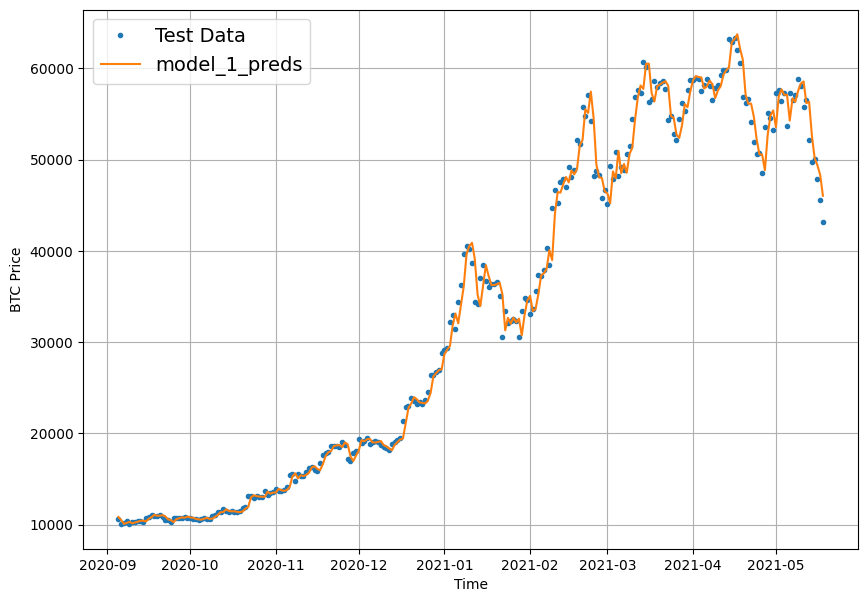

In [58]:
# Let's plot our model 1 predictions
offset = 300
plt.figure(figsize=(10, 7))
# Account for the test_window offset and index into test_labels to ensure correct plotting
plot_time_series(timesteps=x_test[-len(test_windows):],
                 values=test_labels[:, 0],
                 start=offset,
                 label="Test Data")

plot_time_series(timesteps=x_test[-len(test_windows):],
                 values=model_1_preds,
                 start=offset,
                 format="-",
                 label="model_1_preds")

## Model 2: Dense (window = 30, horizon = 1)